<a href="https://colab.research.google.com/github/Sathyapriyaiitm/Projectsiitm/blob/main/dynamic_pricing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 STEP 0: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 📥 STEP 1: Load the Dataset
df = pd.read_csv("dataset.csv")
print("Shape:", df.shape)
df.head()


Shape: (18368, 12)


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
# 🔎 Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# 🧼 Basic cleanup (if needed)
# df.dropna(inplace=True)  # Removed this line to prevent dropping all rows if there are missing values

# 🔄 Time column to datetime
df['Datetime'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format="%d-%m-%Y %H:%M:%S")
df['TimeOnly'] = pd.to_datetime(df['LastUpdatedTime']).dt.time

# ➕ Derived features
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5, 'cycle': 0.5} # Corrected keys
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)

# Normalize numerical features (0 to 1)
# Removed normalization for 'TrafficConditionNearby' as it is categorical
df['Queue_norm'] = (df['QueueLength'] - df['QueueLength'].min()) / (df['QueueLength'].max() - df['QueueLength'].min())



Missing Values:
 ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
Datetime                  0
TimeOnly                  0
OccupancyRate             0
VehicleWeight             0
Queue_norm                0
dtype: int64


/tmp/ipython-input-30-299727785.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeOnly'] = pd.to_datetime(df['LastUpdatedTime']).dt.time


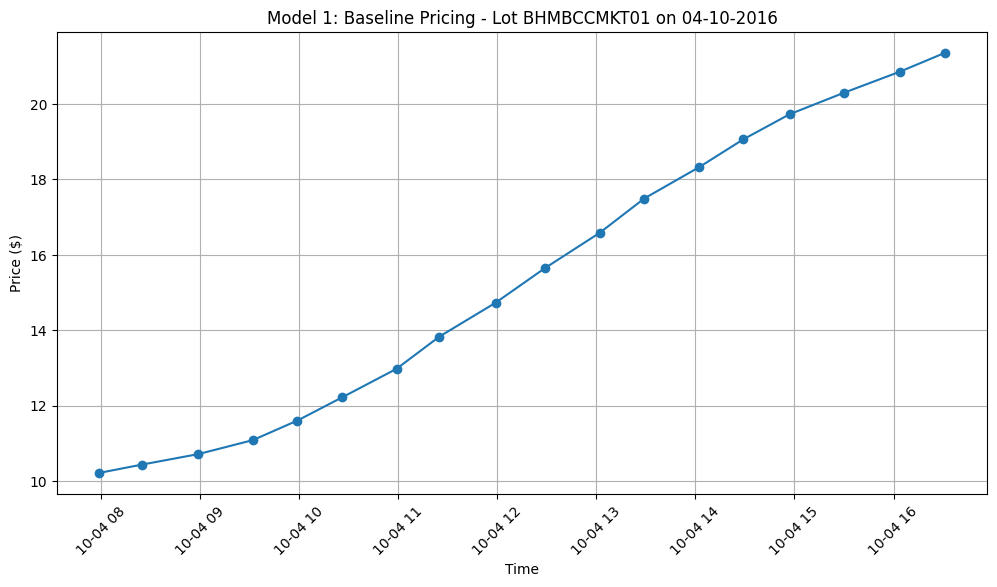

In [ ]:
# 🧠 Simple baseline: Price increases linearly with occupancy
def baseline_pricing(occupancy_rate, prev_price=10, alpha=2.0):
    return prev_price + alpha * occupancy_rate

lot = df['SystemCodeNumber'].unique()[0]
day = df[df['SystemCodeNumber'] == lot]['LastUpdatedDate'].unique()[0]
sample = df[(df['SystemCodeNumber'] == lot) & (df['LastUpdatedDate'] == day)].sort_values('Datetime')

prices = []
price = 10  # Start price
for _, row in sample.iterrows():
    price = baseline_pricing(row['OccupancyRate'], prev_price=price)
    prices.append(price)

# Plot
plt.figure(figsize=(12, 6)) # Add figsize for better readability
plt.plot(sample['Datetime'], prices, marker='o') # Changed 'TimeOnly' to 'Datetime'
plt.xticks(rotation=45)
plt.title(f"Model 1: Baseline Pricing - Lot {lot} on {day}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid()
plt.show()

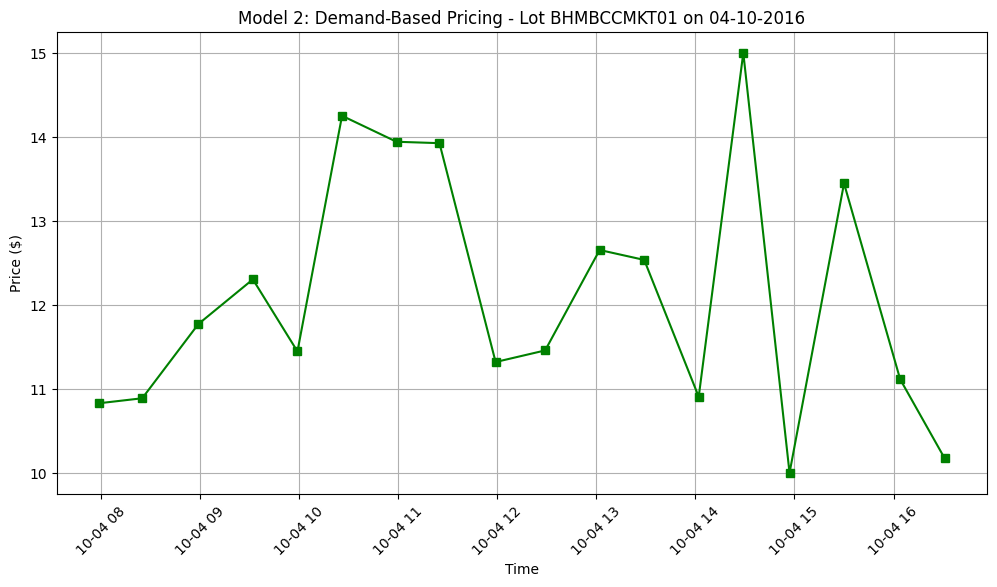

In [ ]:
# # ⚙️ Demand Score Function
def compute_demand(row):
    # Map traffic condition to a numerical value
    traffic_mapping = {'low': 0.5, 'average': 1.0, 'high': 1.5}
    traffic_score = traffic_mapping.get(row['TrafficConditionNearby'], 1.0) # Default to average if category is missing

    return (
        2 * row['OccupancyRate'] +
        1.5 * row['Queue_norm'] -
        1.0 * traffic_score +  # Use the numerical traffic score
        2.0 * row['IsSpecialDay'] +
        1.0 * row['VehicleWeight']
    )

# Calculate & normalize demand
df['DemandRaw'] = df.apply(compute_demand, axis=1)
df['DemandNorm'] = (df['DemandRaw'] - df['DemandRaw'].min()) / (df['DemandRaw'].max() - df['DemandRaw'].min())

# Price function based on demand
def demand_based_price(demand, base_price=10, lam=0.5):
    price = base_price * (1 + lam * demand)
    return min(max(price, 5), 20)  # bounded between $5 and $20

# Sample price computation
# Ensure 'sample' DataFrame is up-to-date with the latest columns
lot = df['SystemCodeNumber'].unique()[0]
day = df[df['SystemCodeNumber'] == lot]['LastUpdatedDate'].unique()[0]
sample = df[(df['SystemCodeNumber'] == lot) & (df['LastUpdatedDate'] == day)].sort_values('Datetime')

sample['DemandNorm'] = sample.apply(compute_demand, axis=1)
sample['DemandNorm'] = (sample['DemandNorm'] - sample['DemandNorm'].min()) / (sample['DemandNorm'].max() - sample['DemandNorm'].min())
sample['Model2Price'] = sample['DemandNorm'].apply(lambda d: demand_based_price(d))

# Plot
plt.figure(figsize=(12, 6)) # Add figsize for better readability
plt.plot(sample['Datetime'], sample['Model2Price'], marker='s', color='green') # Use 'Datetime' for x-axis
plt.xticks(rotation=45)
plt.title(f"Model 2: Demand-Based Pricing - Lot {lot} on {day}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid()
plt.show()

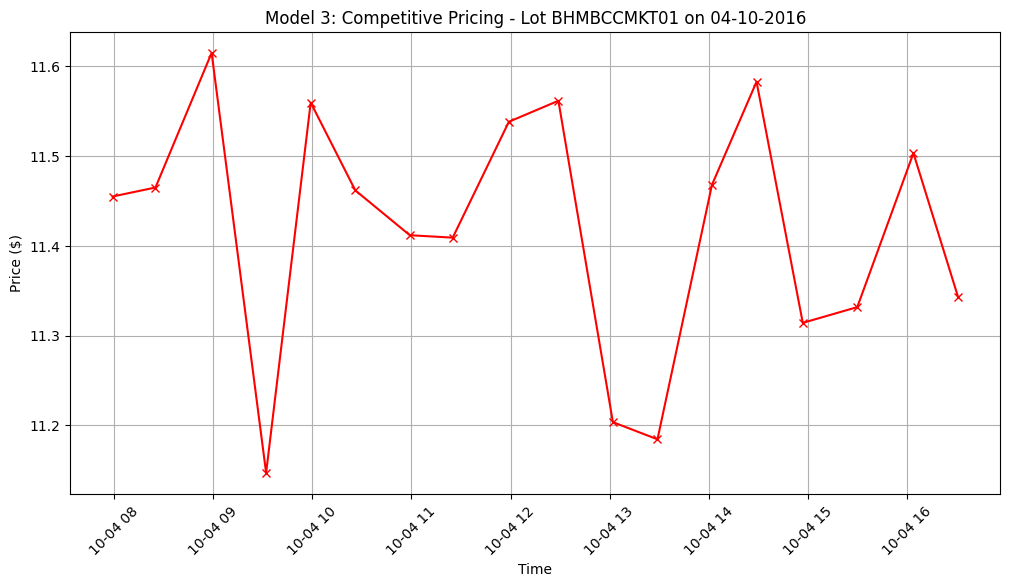

In [ ]:
# --- MODEL 3: COMPETITIVE PRICING MODEL ---

import numpy as np
import matplotlib.pyplot as plt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c * 1000  # Convert to meters

# Get nearby lots within 300m
def get_nearby_lots(df, lat, lon, current_lot_id, threshold=300):
    # Exclude the current lot itself from nearby lots
    nearby_df = df[df['SystemCodeNumber'] != current_lot_id].copy()
    nearby_df['Distance'] = nearby_df.apply(lambda row: haversine(lat, lon, row['Latitude'], row['Longitude']), axis=1)
    return nearby_df[nearby_df['Distance'] < threshold]

# Competitive pricing logic
def competitive_price(row, df_full, base_price=10, lam=0.5):
    demand = row['DemandNorm']
    price = base_price * (1 + lam * demand)

    # Nearby lot logic
    lot_lat, lot_lon = row['Latitude'], row['Longitude']
    current_lot_id = row['SystemCodeNumber']
    # Get nearby lots from the full DataFrame (df_full) for a realistic comparison
    nearby = get_nearby_lots(df_full, lot_lat, lot_lon, current_lot_id)

    nearby_prices = base_price # Start with base price if no nearby lots

    if not nearby.empty:
        # Calculate demand and price for nearby lots using the existing functions
        nearby['DemandRaw'] = nearby.apply(compute_demand, axis=1)
        # Normalize nearby demand based on the full dataset's demand range
        nearby['DemandNorm'] = (nearby['DemandRaw'] - df_full['DemandRaw'].min()) / (df_full['DemandRaw'].max() - df_full['DemandRaw'].min())
        nearby['CalculatedPrice'] = nearby['DemandNorm'].apply(lambda d: demand_based_price(d, base_price=base_price, lam=lam))
        nearby_prices = nearby['CalculatedPrice'].mean()

    # Competitive adjustment rules
    if row['OccupancyRate'] >= 0.95 and price > nearby_prices:
        price = max(nearby_prices * 0.9, 5)  # Drop price, but not below $5
    elif nearby_prices > price * 1.1: # If nearby prices are significantly higher
        price = min(price * 1.05, 20)  # Slightly raise price, but not above $20


    return min(max(price, 5), 20) # bounded between $5 and $20

# Apply on a sample
# Ensure 'sample' DataFrame is up-to-date with the latest columns including 'DemandNorm'
lot = df['SystemCodeNumber'].unique()[0]
day = df[df['SystemCodeNumber'] == lot]['LastUpdatedDate'].unique()[0]
sample = df[(df['SystemCodeNumber'] == lot) & (df['LastUpdatedDate'] == day)].sort_values('Datetime').copy() # Use .copy() to avoid SettingWithCopyWarning

# Recalculate DemandNorm for the sample to ensure it's based on the full df's min/max
sample['DemandRaw'] = sample.apply(compute_demand, axis=1)
sample['DemandNorm'] = (sample['DemandRaw'] - df['DemandRaw'].min()) / (df['DemandRaw'].max() - df['DemandRaw'].min())


# Apply the competitive pricing function, passing the full DataFrame
sample['Model3Price'] = sample.apply(lambda row: competitive_price(row, df_full=df), axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sample['Datetime'], sample['Model3Price'], marker='x', color='red') # Use 'Datetime' for x-axis
plt.xticks(rotation=45)
plt.title(f"Model 3: Competitive Pricing - Lot {lot} on {day}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid()
plt.show()

In [ ]:
# --- REAL-TIME STREAMING SIMULATION WITH PATHWAY (Minimal) ---

import pathway as pw

# Define schema
class InputSchema(pw.Schema):
    LotID: str
    OccupancyRate: float
    Queue_norm: float
    Traffic_norm: float
    IsSpecialDay: int
    VehicleWeight: float
    Latitude: float
    Longitude: float

# Pricing logic inside Pathway
@pw.udf
def pathway_demand_price(occ, queue, traffic, special, vweight):
    demand = 2*occ + 1.5*queue - 1.0*traffic + 2*special + 1.0*vweight
    norm_demand = min(max((demand - 2)/5, 0), 1)  # Fake normalization
    return 10 * (1 + 0.5 * norm_demand)

input_stream = pw.io.csv.read("stream.csv", schema=InputSchema, mode="streaming")

output = input_stream.select(
    LotID = input_stream.LotID,
    Price = pathway_demand_price(
        input_stream.OccupancyRate,
        input_stream.Queue_norm,
        input_stream.Traffic_norm,
        input_stream.IsSpecialDay,
        input_stream.VehicleWeight
    )
)

pw.io.csv.write(output, "predicted_prices.csv")

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

output_notebook()

# Sample plot
source = ColumnDataSource(data={
    'time': sample['LastUpdatedTime'],
    'price': sample['Model3Price']
})

p = figure(x_range=list(map(str, sample['LastUpdatedTime'])), height=400, title="Real-Time Pricing Visualization")
p.line(x='time', y='price', source=source, line_width=2, color='green')
p.xaxis.major_label_orientation = 0.8
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"

show(p)